# Цель

Построение прогноза временного ряда с использованием изученных методов.

In [182]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()
import plotly.graph_objects as go

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import requests
import json

 # Датасет

В качестве датасета будем использовать данные акций компании Microsoft и попробуем предсказать их изученными методами.

Данные будем брать с сайта https://www.alphavantage.co с использованием `API`. Для этого напишем класс-провайдер. для получения данных за любой период. 

In [357]:
class AlphaVantageProvider:
    _url = 'https://www.alphavantage.co/query'
    
    def __init__(self, apikey = 'demo'):
        self._apikey = apikey
    
    def get_stock_data(self, function='TIME_SERIES_DAILY', symbol='MSFT'):
        params = {
            'function': function,
            'symbol': symbol,
            'outputsize': 'full',
            'apikey': self._apikey
        }
        
        response = requests.get(self._url, params)
        
        return json.loads(response.content)

Получим данные с дискритизацией за один день.

In [203]:
API_KEY = 'demo'
avp = AlphaVantageProvider(apikey=API_KEY)

In [204]:
stock = avp.get_stock_data(function='TIME_SERIES_DAILY', symbol='MSFT')
stock.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

Выведем полученный график.

In [447]:
df_stock = pd.DataFrame(stock['Time Series (Daily)']).T

fig = go.Figure(data=[
    go.Candlestick(
        x=df_stock.index,
        open=df_stock['1. open'], 
        high=df_stock['2. high'],
        low=df_stock['3. low'], 
        close=df_stock['4. close'],
        name="Test"
    )
])

fig.update_layout(
    title='Курс акций',
    yaxis_title='MSFT',
    xaxis_rangeslider_visible=False
)
fig.show()

# Подготовка данных

Преобразуем данные по свечам в двумерное представление.

In [412]:
high_prices = pd.to_numeric(df_stock['1. open']).as_matrix()
low_prices = pd.to_numeric(df_stock['3. low']).as_matrix()
df = pd.DataFrame((high_prices+low_prices)/2.0)

df.index = pd.to_datetime(df_stock.index)
df.rename(columns={0:'y'}, inplace=True)

In [413]:
df.head(5)

,y
2020-01-17,166.425
2020-01-16,164.190
2020-01-15,162.595
2020-01-14,162.555
2020-01-13,161.510


Выведем преобразованный график.

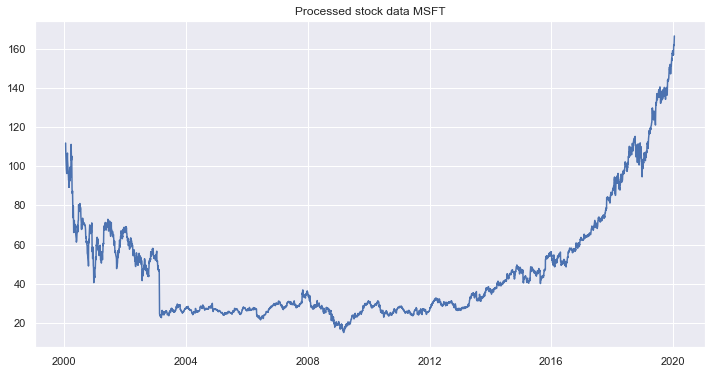

In [414]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('Processed stock data MSFT')
plt.grid(True)
plt.show()

Отметим дату `2016 г.`, где начался стабильный рост акций компании.

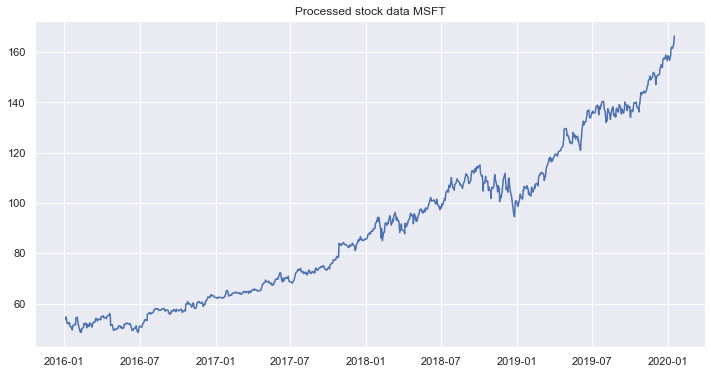

In [497]:
df_2016_2020 = df[df.index > '2016']

plt.figure(figsize=(12, 6))
plt.plot(df_2016_2020)
plt.title('Processed stock data MSFT')
plt.grid(True)
plt.show()

Создадим новые признаки по лагам.

In [498]:
for i in range(6, 35):
    df_2016_2020["lag_{}".format(i)] = df_2016_2020.y.shift(i)

df_2016_2020.dropna(inplace=True)

In [499]:
df_2016_2020.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34
2019-11-27,151.9250,150.630,150.990,151.0275,150.9350,151.3350,152.9703,154.9650,154.9500,154.2400,...,156.79500,158.320,158.43955,161.43250,162.00175,161.51000,162.55500,162.59500,164.19000,166.425
2019-11-26,151.3400,149.765,150.630,150.9900,151.0275,150.9350,151.3350,152.9703,154.9650,154.9500,...,158.19000,156.795,158.32000,158.43955,161.43250,162.00175,161.51000,162.55500,162.59500,164.190
2019-11-25,149.9600,149.670,149.765,150.6300,150.9900,151.0275,150.9350,151.3350,152.9703,154.9650,...,158.55500,158.190,156.79500,158.32000,158.43955,161.43250,162.00175,161.51000,162.55500,162.595
2019-11-22,149.4450,147.070,149.670,149.7650,150.6300,150.9900,151.0275,150.9350,151.3350,152.9703,...,156.61000,158.555,158.19000,156.79500,158.32000,158.43955,161.43250,162.00175,161.51000,162.555
2019-11-21,148.9505,150.065,147.070,149.6700,149.7650,150.6300,150.9900,151.0275,150.9350,151.3350,...,157.85825,156.610,158.55500,158.19000,156.79500,158.32000,158.43955,161.43250,162.00175,161.510


Опишем функции для разделения датасета на тестовый и тренировочный.

In [500]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [501]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

# Обучение моделей

Разделим датасет на признаки и целевую переменную.

In [502]:
y = df_2016_2020.dropna().y
X = df_2016_2020.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## Линейная регрессия

Произведем тренировку по линейной регрессии.

In [503]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [504]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Визуализируем результаты.

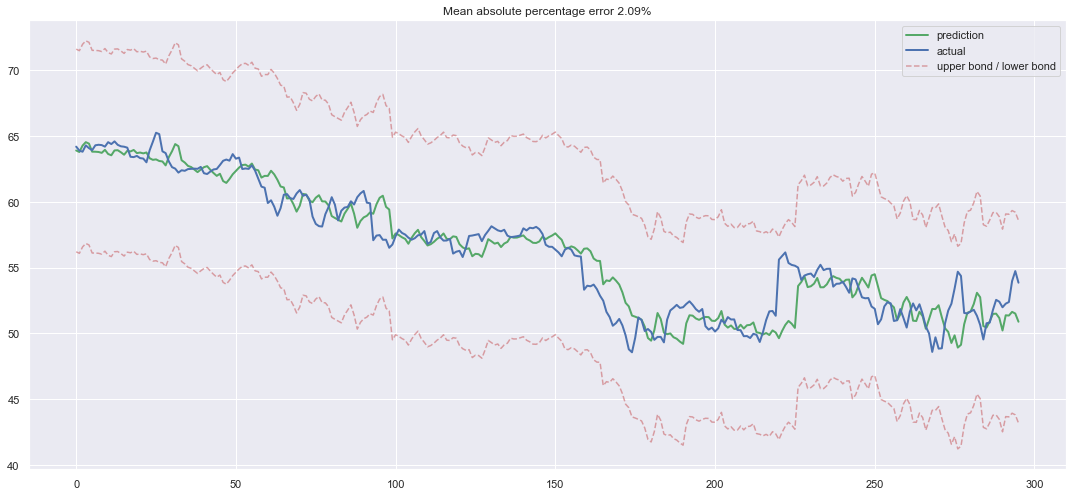

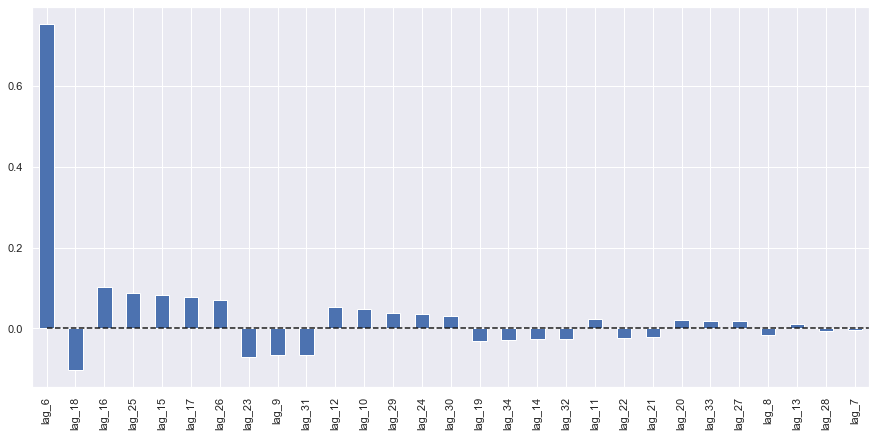

In [505]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Получили ошибку `MAPE = 2.09%` и признаком `lag_6`, который оказывает наибольшее влияние на цену.

Создадим дополнительные признаки: 
- `weekday`- день недели
- `is_weekend` - конец недели

In [506]:
df_2016_2020['weekday'] = df_2016_2020.index.weekday
df_2016_2020['is_weekend'] = df_2016_2020.index.weekday.isin([5,6])*1
df_2016_2020.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,weekday,is_weekend
2016-01-08,52.260,50.7700,49.5400,50.650,51.335,51.795,51.670,51.51505,51.55500,54.36500,...,52.215,51.750,52.280,51.660,50.445,51.170,51.850,51.005,4,0
2016-01-07,52.385,50.8250,50.7700,49.540,50.650,51.335,51.795,51.67000,51.51505,51.55500,...,51.470,52.215,51.750,52.280,51.660,50.445,51.170,51.850,3,0
2016-01-06,53.980,51.7850,50.8250,50.770,49.540,50.650,51.335,51.79500,51.67000,51.51505,...,50.515,51.470,52.215,51.750,52.280,51.660,50.445,51.170,2,0
2016-01-05,54.735,52.5519,51.7850,50.825,50.770,49.540,50.650,51.33500,51.79500,51.67000,...,50.000,50.515,51.470,52.215,51.750,52.280,51.660,50.445,1,0
2016-01-04,53.855,52.4100,52.5519,51.785,50.825,50.770,49.540,50.65000,51.33500,51.79500,...,48.595,50.000,50.515,51.470,52.215,51.750,52.280,51.660,0,0


Посмотрим их влияние на цену.

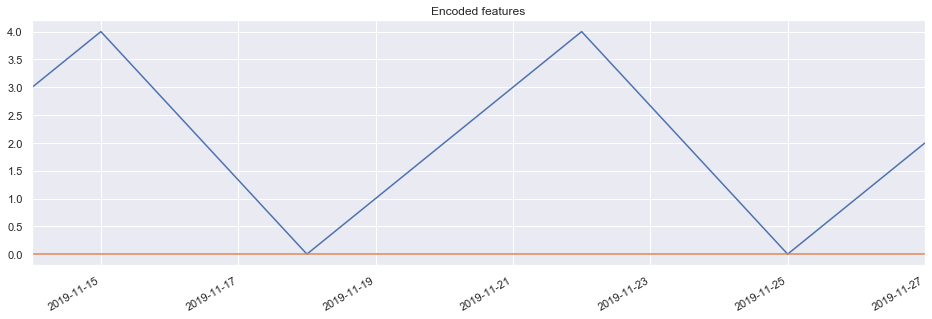

In [507]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
df_2016_2020.head(10).weekday.plot()
df_2016_2020.head(10).is_weekend.plot()
plt.grid(True);

Эти признаки никак не влияют на цену.

Попробуем произвести шкалирование данных.

In [508]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

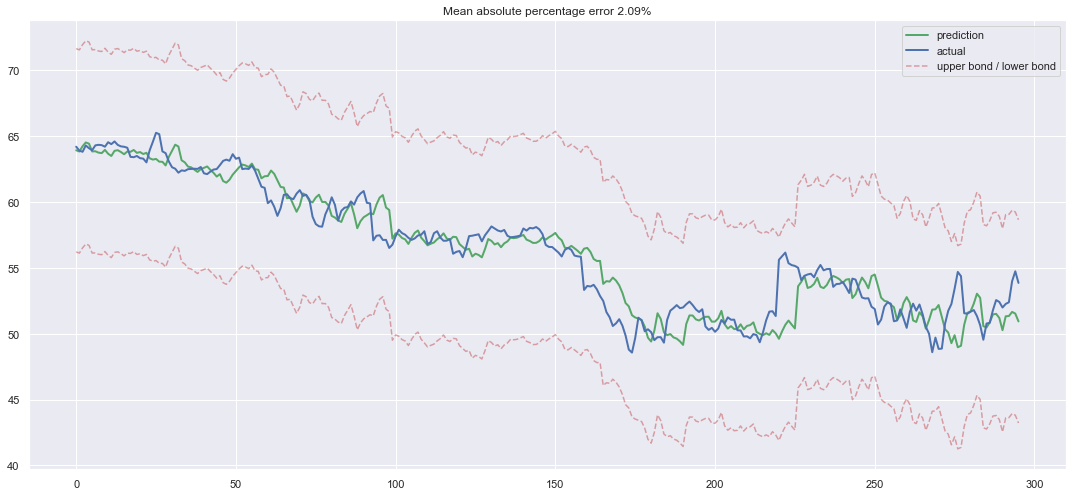

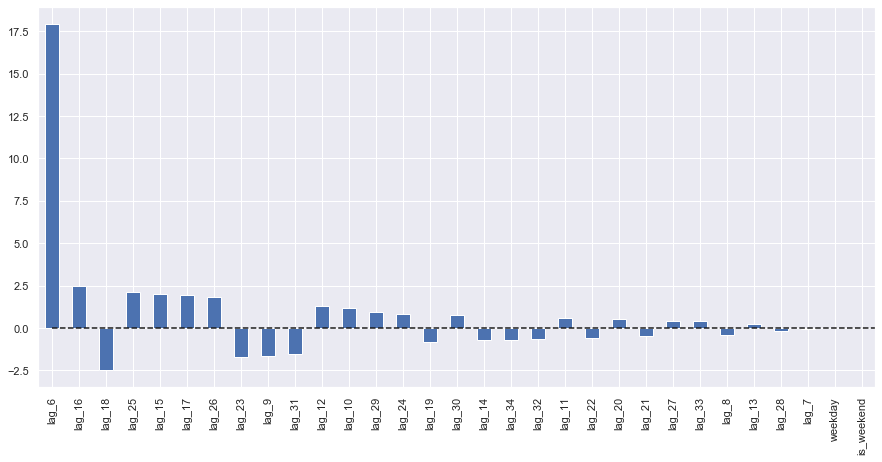

In [509]:
y = df_2016_2020.dropna().y
X = df_2016_2020.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Получили аналогичную ошибку `MAPE = 2.09%`. Шкалирование не улучшило результат.

## Ридж-регрессия

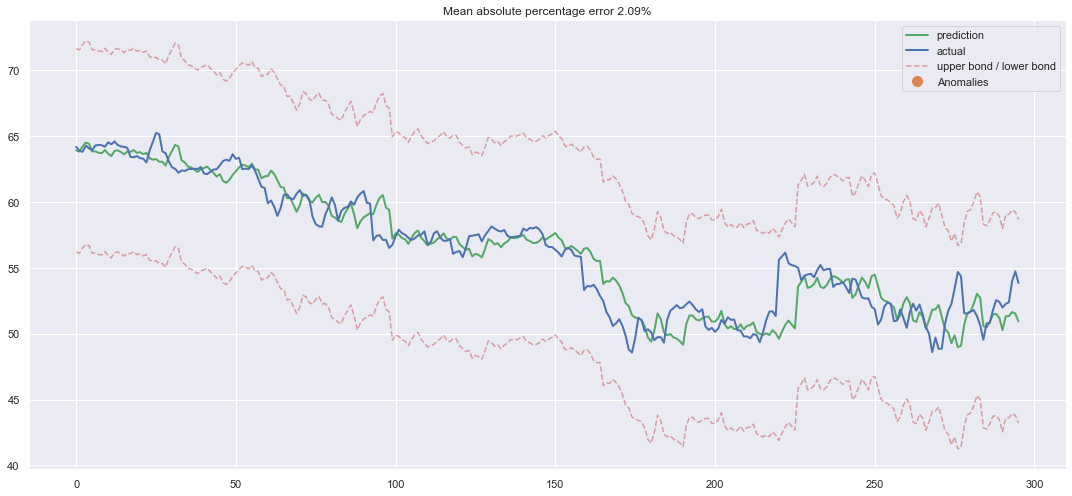

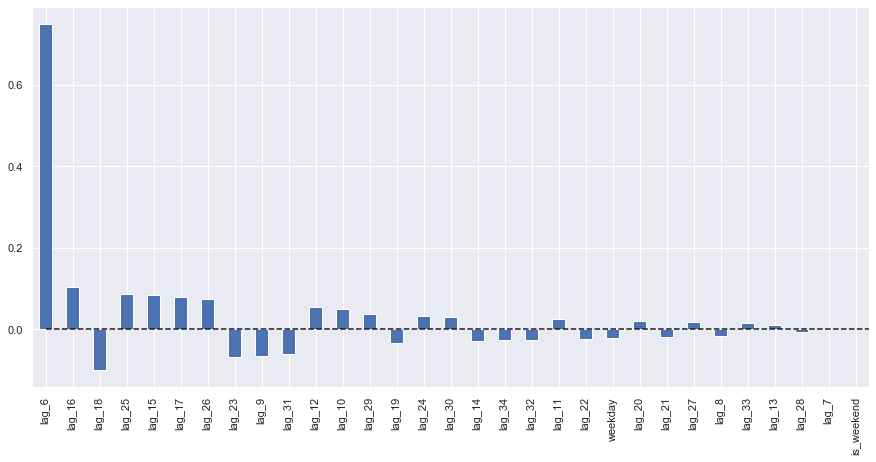

In [510]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

Ридж-регрессия имеет аналогичный результат `MAPE = 2.09%`. Методы понижения размерности не помогли улучшить результат.

## Лассо-регрессия

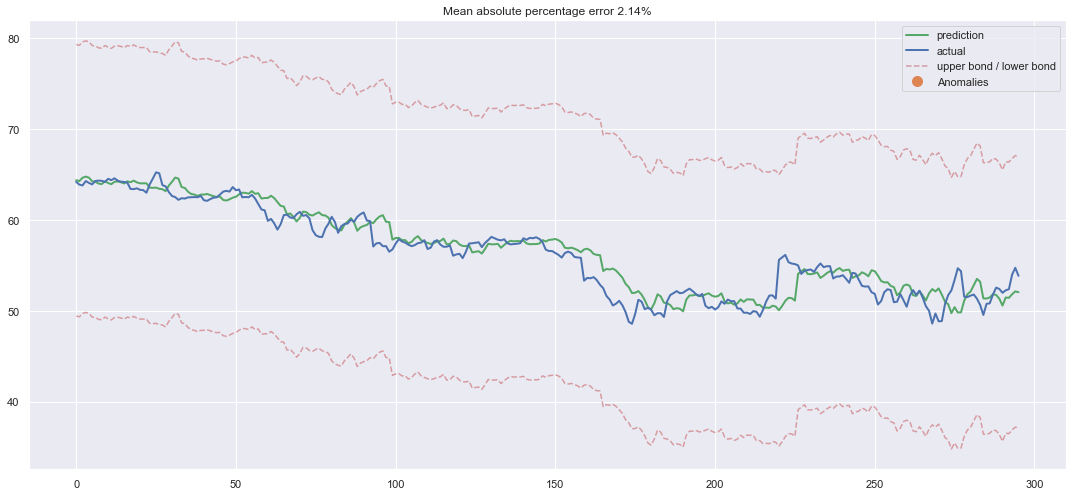

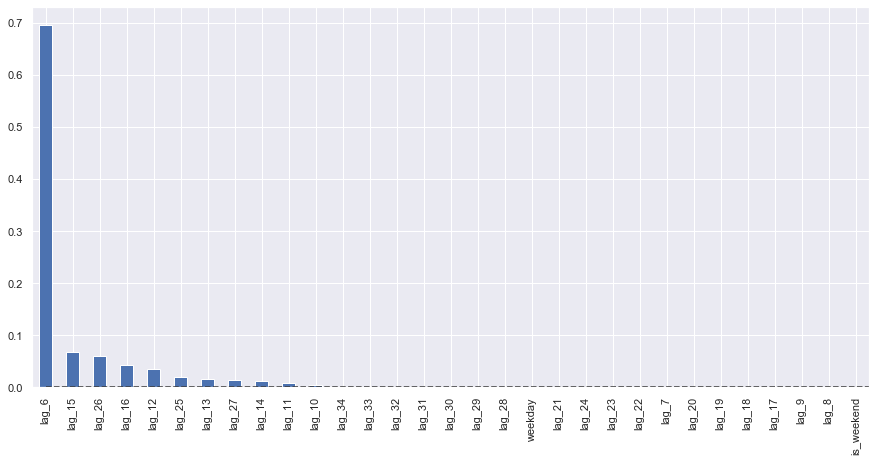

In [511]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Лассо-регрессия увеличила ошибку до `MAPE = 2.14%`

## Ада-бустинг

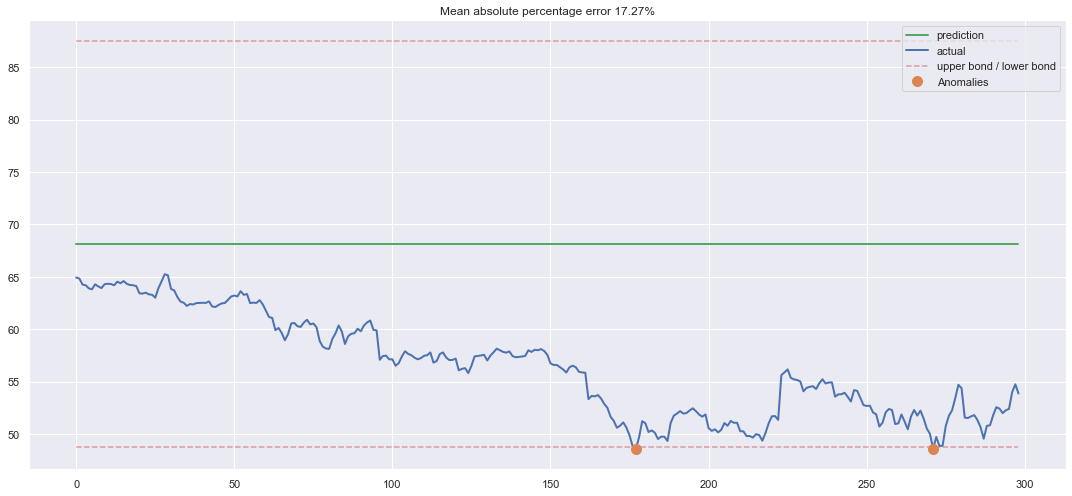

In [430]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Рузельтат получился хуже - `MAPE = 17.27%`

## CatBoost

Напишем функции для подготовки данных

In [395]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False, get_dummies=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
            
        get_dummies: boolean
            if True - encode categorical into dummies
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
#     data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#         data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
#         data.drop(["hour", "weekday"], axis=1, inplace=True)
        data.drop(["weekday"], axis=1, inplace=True)
        
    if get_dummies:
#         data = pd.get_dummies(data, columns=['hour', 'weekday'])
        data = pd.get_dummies(data, columns=['weekday'])
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [396]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

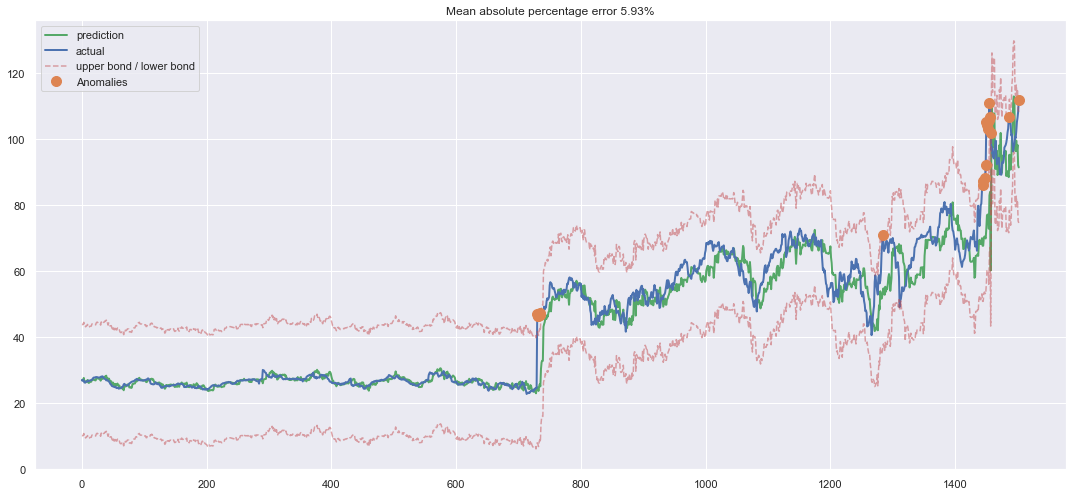

In [431]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test =\
prepareData(df[['y']], lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Результат хуже линейных методов - `MAPE = 5.93%`

---

# Выводы

1. Был разарботан класс для получения данных котировок акций Microsoft.
2. Над полученными данными были применены методы, изученные на лекциях.
3. Данные котировок акций не имеют структуры и трудны для обработки моделями